<a href="https://colab.research.google.com/github/RomaricKanyamibwa/Cours_2017/blob/master/ForestCoverTypePrediction_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Restrict minor warnings
import warnings
warnings.filterwarnings('ignore')

#Import Data

In [0]:
#Import Data
col_names=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type']

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
covtype=pd.read_csv(data_url,delimiter=",",header =None,names=col_names)

In [3]:
#Distribution des differents Cover Type
tab=covtype["Cover_Type"].value_counts(ascending=True)
print(tab)

4      2747
5      9493
6     17367
7     20510
3     35754
1    211840
2    283301
Name: Cover_Type, dtype: int64


on observe que les données ne sont pas du tout equilibré

# Construction des données equilibré

In [4]:
covtype_balanced=covtype[covtype['Cover_Type']==4].sample(frac=0.4)
frames = [covtype_balanced]

for i in range(1,8):
  if i!=4:
    frames.append(covtype[covtype['Cover_Type']==i].sample(n=int(len(covtype_balanced)*(1+random.uniform(0.5, 2)))))

covtype_balanced=pd.concat(frames)
covtype_balanced=covtype_balanced.sample(frac=1)#.reset_index(drop=True)#melange des données
tab=covtype_balanced["Cover_Type"].value_counts(ascending=True)
print(tab)
print("Balanced Data Size:",len(covtype_balanced))

4    1099
3    2109
2    2351
1    2380
5    2708
6    2892
7    3118
Name: Cover_Type, dtype: int64
Balanced Data Size: 16657


In [5]:
covtype_balanced.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,...,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000,16657.000000
mean,2811.433992,158.394609,16.319685,240.314042,51.872726,1810.728463,211.324248,219.107342,137.093054,1594.184127,...,0.047848,0.042445,0.001381,0.008165,0.001021,0.002341,0.060995,0.055412,0.038002,4.233836
std,409.126296,112.195654,8.369982,216.367109,61.565875,1353.275099,30.530740,22.814164,45.045723,1115.390346,...,0.213450,0.201607,0.037135,0.089992,0.031931,0.048332,0.239329,0.228790,0.191207,2.112929
min,1877.000000,0.000000,0.000000,0.000000,-134.000000,0.000000,0.000000,98.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2470.000000,63.000000,10.000000,85.000000,6.000000,805.000000,195.000000,207.000000,110.000000,792.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2810.000000,127.000000,15.000000,190.000000,34.000000,1433.000000,218.000000,223.000000,140.000000,1342.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,3184.000000,269.000000,22.000000,339.000000,80.000000,2469.000000,234.000000,236.000000,169.000000,2108.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3846.000000,360.000000,53.000000,1321.000000,540.000000,6882.000000,254.000000,254.000000,248.000000,7050.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


# Analyse de données 
verifiecation des proprietes vu dans le dataset globale

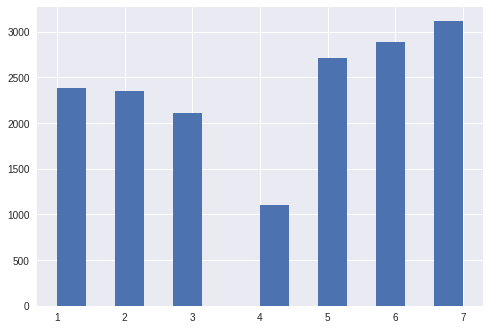

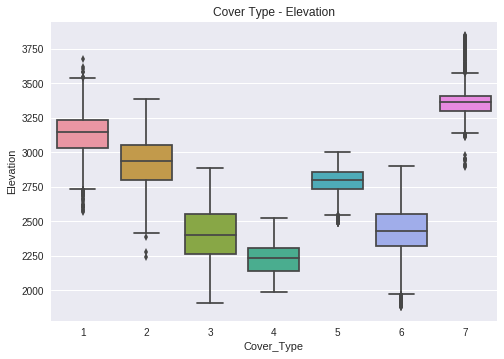

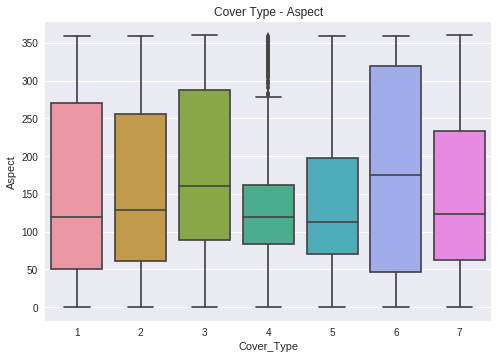

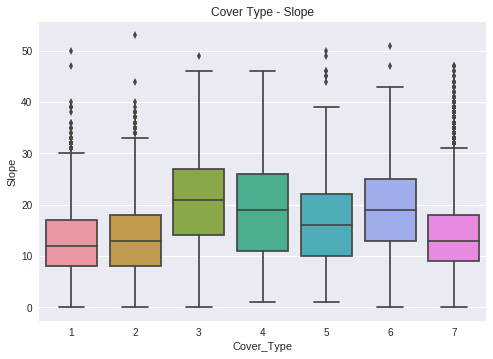

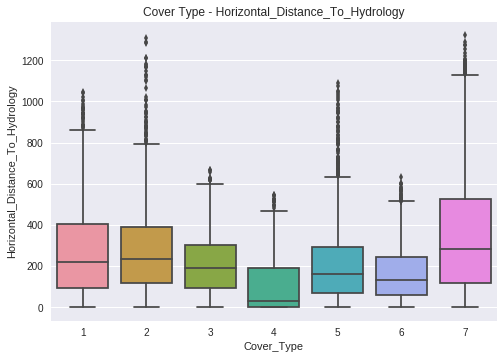

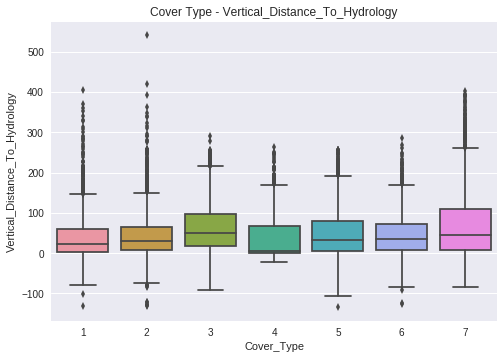

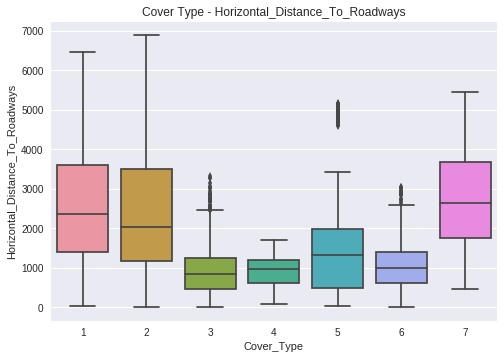

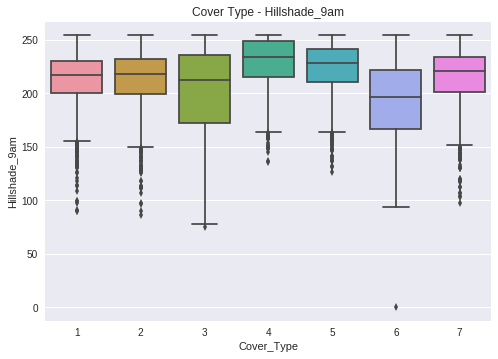

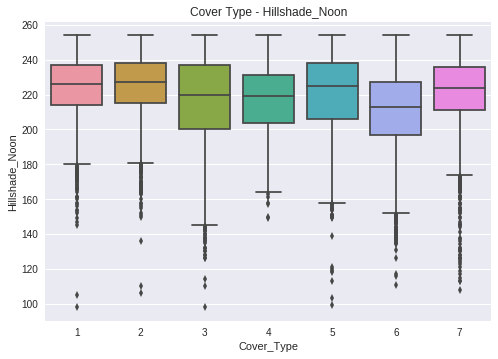

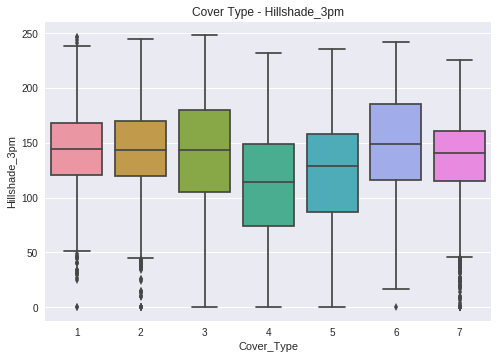

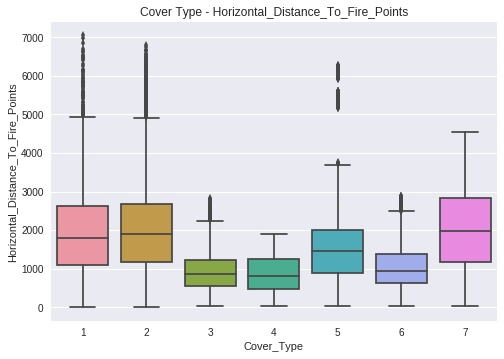

In [6]:
#Histograme 
covtype_balanced['Cover_Type'].hist(bins=2*7);
plt.show()
#sns.boxplot(x="Cover_Type",y="Elevation", data=covtype);
cols = covtype_balanced.columns
size = 10#len(cols) - 1 # on enleve cover_type
# l'axe de x  represente les 7 classes classes
x = cols[-1]
y = cols[0:size]

for i in range(0, size):
    ax=sns.boxplot(data=covtype_balanced, x=x, y=y[i])
    title="Cover Type - "+col_names[i]
    ax.set_title(title)
    #ax = sns.swarmplot(data=covtype, x=x, y=y[i])
    plt.show()

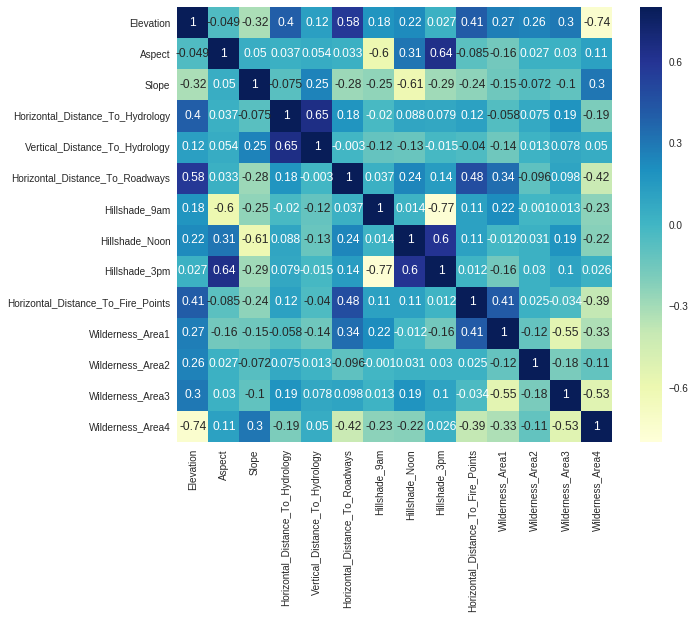

In [7]:
#Matrice de correlation ,on va  étudier l'intensité de la liaison qui peut exister entre les differents variables

size = 14
corrmat = covtype_balanced.iloc[:,:size].corr()
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,cmap="YlGnBu");

# Selection des Variables 
**Feature importances**

In [0]:
#Seletion des variables avec l'attribut feature_importances des arbres de classifications
def best_n_features(data,n=10,n_classes=7):
  X = data.iloc[:,:-1]  #independent columns
  y = data.iloc[:,-1]    #target column i.e price range

  model = ExtraTreesClassifier(n_classes)
  model.fit(X,y)
  #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
  #plot graph of feature importances for better visualization
  feat_importances = pd.Series(model.feature_importances_, index=X.columns)
  feat_importances.nlargest(n).plot(kind='barh')
  #print(list(feat_importances.nlargest(n).index))
  plt.show()
  return (feat_importances)

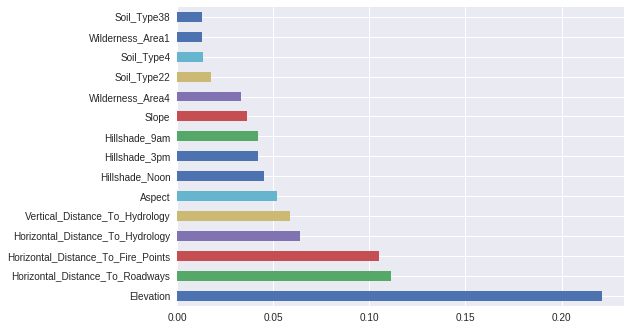

In [9]:
globl_features=best_n_features(covtype,n=15)

**Unvariate feature selection with  chi2**

In [10]:
X = covtype.drop(["Cover_Type","Vertical_Distance_To_Hydrology"],axis=1)  #independent columns
y = covtype.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 15 best features
bestfeatures = SelectKBest(score_func=chi2, k=15)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 15 best features

                                 Specs         Score
4      Horizontal_Distance_To_Roadways  5.766452e+07
8   Horizontal_Distance_To_Fire_Points  3.589090e+07
0                            Elevation  9.479853e+06
3     Horizontal_Distance_To_Hydrology  2.322605e+06
12                    Wilderness_Area4  2.949092e+05
1                               Aspect  2.146782e+05
2                                Slope  1.714326e+05
22                         Soil_Type10  1.219068e+05
16                          Soil_Type4  6.637906e+04
50                         Soil_Type38  6.569458e+04
7                        Hillshade_3pm  6.358794e+04
5                        Hillshade_9am  6.339071e+04
51                         Soil_Type39  6.212286e+04
15                          Soil_Type3  6.109861e+04
14                          Soil_Type2  5.495303e+04


**features selected list**

In [0]:
n_feat=15#number of features
feat=featureScores.nlargest(n_feat,'Score')
list_feat=list(feat['Specs'])
predictors=[list_feat,list(globl_features.nlargest(n_feat).index)] #Our list of features
type_pred=[" Chi2Sel"," FeatImpo"]

# **Construction des Modeles Predictives**

**Train model**

In [0]:
#function generique pour un classifieur et sa performance:
def classification_model(model, data, predictors, outcome):
  #entrainement du model:
  tp_d=time()
  model.fit(data[predictors],data[outcome])
  tr_time = time()-tp_d
  
  #predictions sur le training set:
  predictions = model.predict(data[predictors])
  
  #affichage de l'accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print ("\tAccuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  #kf = KFold(n_splits = 10, shuffle = True)#, random_state = 2
  error = cross_val_score(model,data[predictors],data[outcome], cv=5,n_jobs=4)
 
  print ("\tCross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome])
  return accuracy,tr_time,len(predictors),np.mean(error)

In [0]:
outcome_var = 'Cover_Type'
end=10 #only categorical variables
scaler = StandardScaler()
#we scale to speed up convergence
scaled_covtype_balanced=covtype_balanced.copy()
scaled_covtype_balanced[col_names[:end]]=scaler.fit_transform(scaled_covtype_balanced[col_names[:end]])
#scaled_covtype_balanced.head(5)

In [0]:
TrainingTime=[]
Accuracy=[]
Nb_Features=[]
Classifier=[]
Cross_Validation=[]

In [0]:
names = ["Logit","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest 7","Random Forest 100","Random Forest 500", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(solver='lbfgs',multi_class='auto',max_iter = 450,n_jobs=4),
    KNeighborsClassifier(7,n_jobs=4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0),n_jobs=4),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1,n_jobs=4,bootstrap=True),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1,n_jobs=4,bootstrap=True),
    RandomForestClassifier(max_depth=5, n_estimators=500, max_features=1,n_jobs=4,bootstrap=True),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

**Training**

In [0]:
for clsf_index,clsf in enumerate(classifiers):
  print("--------",names[clsf_index]," with ",n_feat," best feature(s)","--------")
  for k,pred in enumerate(predictors):
      accuracy,tr_time,nb_features,cross_val=classification_model(
          clsf, scaled_covtype_balanced,
          pred,outcome_var)
  
      classifier_type=names[clsf_index]+type_pred[k]

      TrainingTime.append(tr_time)
      Accuracy.append(accuracy)
      Nb_Features.append(nb_features)
      Classifier.append(classifier_type)
      Cross_Validation.append(cross_val)

In [0]:
d = {'Type of Classifier':Classifier,'Number of Features':Nb_Features,
     'Training Time': TrainingTime, 'Accuracy': Accuracy,'Cross-Validation':Cross_Validation}

df2 = pd.DataFrame(data=d)
df2 = df2[list(d.keys())]
df2[df2["Number of Features"]<=15].sort_values(by=['Accuracy'],ascending=False).head(50)

# Model testing

In [19]:
testcovtype=covtype.drop(covtype_balanced.index)
testcovtype.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,...,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000,564355.000000
mean,2963.731509,155.576001,14.038299,270.287525,46.257884,2366.067598,212.170304,223.443015,142.688684,1991.687220,...,0.091648,0.078757,0.002814,0.003110,0.000181,0.000459,0.025794,0.022828,0.014383,1.987058
std,274.044056,111.904471,7.450636,212.375196,58.188197,1562.096103,26.650471,19.657968,38.044628,1328.156675,...,0.288529,0.269360,0.052971,0.055678,0.013443,0.021418,0.158521,0.149354,0.119063,1.315790
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2817.000000,58.000000,9.000000,108.000000,7.000000,1115.000000,198.000000,213.000000,119.000000,1034.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2998.000000,127.000000,13.000000,228.000000,29.000000,2016.000000,218.000000,226.000000,143.000000,1719.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,390.000000,68.000000,3348.000000,231.000000,237.000000,168.000000,2561.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [0]:
def test_model(model,data,predictors,outcome):
  
  score=model.score(data[predictors],data[outcome])
  print ("Accuracy : %s" % "{0:.3%}".format(score))
  

In [0]:
for clsf_index,clsf in enumerate(classifiers):
  print("--------",names[clsf_index]," Testing ","--------")
  test_model(clsf,testcovtype,predictors[1],outcome_var)

-------- Logit  Testing  --------
Accuracy : 3.082%
-------- Nearest Neighbors  Testing  --------
Accuracy : 22.047%
-------- Linear SVM  Testing  --------
Accuracy : 3.082%
-------- RBF SVM  Testing  --------
